In [3]:
import os
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize
import numpy as np
import pandas as pd
import random as ran
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from keras import  models, layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

In [5]:
image_dir = os.path.dirname(os.getcwd())+"\\Screenshots\\"
filenames = os.listdir(image_dir)
labels = [x.split("_")[0] for x in filenames]
img = [imread(image_dir + x) for x in filenames]

data = pd.DataFrame({"filename": filenames, "label": labels, "img": img})

for index, row in data.iterrows():
    img = imread(image_dir + row["filename"])
    img = resize(img, (80,80))
    data.loc[index, "img"] = img

data = data.reset_index()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  1232 non-null   object 
 1   label     1232 non-null   object 
 2   img       1232 non-null   object 
 3   distance  1232 non-null   float64
dtypes: float64(1), object(3)
memory usage: 38.6+ KB


In [6]:
#Splitting the data into training and testing
train_df, test_df = train_test_split(data, test_size=0.3)

# Datagen for training data. Augment the data by rotating, shifting, flipping, to make the model more robust and less prone to overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(dataframe = train_df,
    directory=image_dir,
    target_size=(64, 64),
    x_col='filename',
    y_col='label',
    batch_size=32,
    class_mode='categorical'  # or 'categorical' based on your problem
)



Found 862 validated image filenames belonging to 5 classes.


In [8]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(64, 64),
    batch_size=32,
    class_mode= "categorical"  # or 'categorical'
)

Found 216 validated image filenames belonging to 5 classes.


In [11]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),  # Adjust input_shape based on your image dimensions
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    # Add more layers as needed
    Flatten(),
    Dense(512, activation='relu'),
    Dense(5, activation='softmax')  # or more units with 'softmax' for multi-class classification
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
trained_model = model.fit(train_generator,validation_data = test_generator, epochs=30)

C:\Users\krist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TypeError: TensorFlowTrainer.fit() got an unexpected keyword argument 'lr'

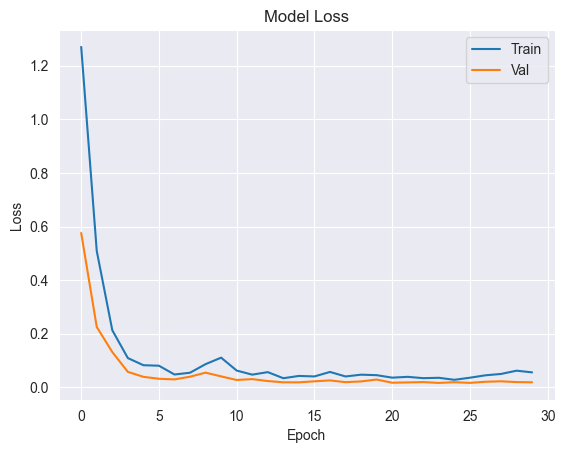

In [10]:
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

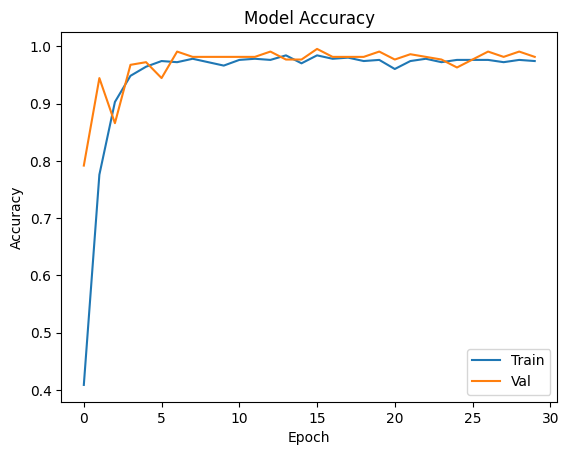

In [20]:
plt.plot(trained_model.history['accuracy'])
plt.plot(trained_model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()